# 03_Train_Transfer.ipynb
### Transfer Learning (MobileNetV2 / ResNet50) on FER2013
This notebook trains a transfer-learning model on preprocessed images (224×224 RGB) and saves the best checkpoint.
Expected data layout: `data/cropped_faces/train/<class>/...` and `data/cropped_faces/val/<class>/...`

In [5]:
# Install dependencies (run once)
!pip install tensorflow opencv-python matplotlib numpy pandas tqdm seaborn --quiet

In [6]:
import numpy as np
import os, warnings
import absl.logging
import seaborn as sns
import tensorflow as tf
from tqdm import TqdmWarning
import matplotlib.pyplot as plt
from tqdm.keras import TqdmCallback

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2, ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
warnings.filterwarnings("ignore", category=TqdmWarning)

In [7]:
# Parameters (edit as needed)
DATA_DIR = '../data/cropped_faces'
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
VAL_DIR = os.path.join(DATA_DIR, 'val')
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 30
BACKBONE = 'mobilenet'  # options: 'mobilenet' or 'resnet50'
OUT_MODEL = '../models/mobilenet_emotion.h5'
UNFREEZE_LAYERS = 30  # number of layers from base to keep trainable when fine-tuning
os.makedirs('../models', exist_ok=True)

In [8]:
# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)
val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)
val_gen = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)
NUM_CLASSES = train_gen.num_classes
CLASS_INDICES = train_gen.class_indices
print('Classes:', CLASS_INDICES)

Found 30503 images belonging to 7 classes.
Found 5384 images belonging to 7 classes.
Classes: {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6}


In [9]:
# Build model function
def build_model(backbone='mobilenet', input_shape=(224,224,3), num_classes=7, dropout=0.5):
    if backbone == 'mobilenet':
        base = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    elif backbone == 'resnet50':
        base = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    else:
        raise ValueError('Unsupported backbone')
    base.trainable = False
    inputs = Input(shape=input_shape)
    x = base(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(dropout)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)
    return model, base

In [10]:
# Create model
model, base = build_model(backbone=BACKBONE, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), num_classes=NUM_CLASSES)
model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │         8,967 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,266,951 (8.65 MB)

 Trainable params: 8,967 (35.03 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [11]:
# Callbacks
callbacks = [
    ModelCheckpoint(OUT_MODEL, save_best_only=True, monitor='val_loss'),
    EarlyStopping(patience=7, restore_best_weights=True, monitor='val_loss'),
    ReduceLROnPlateau(factor=0.5, patience=3, monitor='val_loss')
]

In [12]:
# Train (feature extraction)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
tf.get_logger().setLevel("ERROR")
tf.autograph.set_verbosity(0)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
warnings.filterwarnings("ignore")
absl.logging.set_verbosity(absl.logging.ERROR)
try:
    tf.keras.utils.disable_interactive_logging()
except Exception:
    pass

checkpoint = ModelCheckpoint(
    "../models/best_feature_extractor.keras",
    monitor="val_loss",
    save_best_only=True,
    mode="min"
)
callbacks = [checkpoint] + callbacks if 'callbacks' in locals() else [checkpoint]
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=[TqdmCallback(verbose=1)] + callbacks,
    verbose=0
)
print("\n✅ Feature extraction training complete!")

100%|██████████| 30/30 [3:39:52<00:00, 439.74s/epoch, accuracy=0.424, loss=1.5, val_accuracy=0.469, val_loss=1.43]   


✅ Feature extraction training complete!


In [13]:
# Fine-tune: unfreeze last UNFREEZE_LAYERS of base
base.trainable = True
if UNFREEZE_LAYERS > 0:
    for layer in base.layers[:-UNFREEZE_LAYERS]:
        layer.trainable = False

model.compile(optimizer=Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
ft_history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=callbacks
)
model.save(OUT_MODEL)
print('Saved model to', OUT_MODEL)

Saved model to ../models/mobilenet_emotion.h5


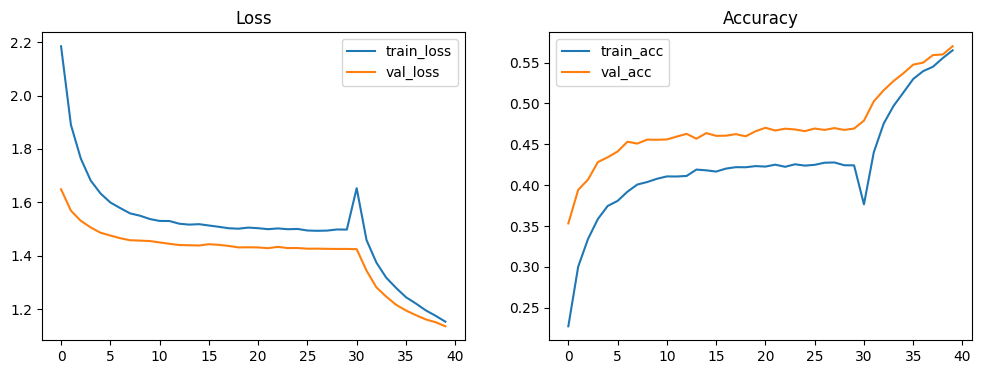

In [14]:
# Plot training curves (combined)
def plot_hist(hist, label_prefix=''):
    h = hist.history
    return h.get('loss', []), h.get('val_loss', []), h.get('accuracy', []), h.get('val_accuracy', [])

loss1, vloss1, acc1, vacc1 = plot_hist(history)
loss2, vloss2, acc2, vacc2 = plot_hist(ft_history)

loss = loss1 + loss2
vloss = vloss1 + vloss2
acc = acc1 + acc2
vacc = vacc1 + vacc2

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(loss, label='train_loss')
plt.plot(vloss, label='val_loss')
plt.legend(); plt.title('Loss')
plt.subplot(1,2,2)
plt.plot(acc, label='train_acc')
plt.plot(vacc, label='val_acc')
plt.legend(); plt.title('Accuracy')
plt.show()


Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.44      0.46       743
           1       0.75      0.07      0.13        82
           2       0.44      0.25      0.32       768
           3       0.79      0.82      0.80      1349
           4       0.43      0.52      0.47       912
           5       0.70      0.66      0.68       600
           6       0.48      0.61      0.54       930

    accuracy                           0.57      5384
   macro avg       0.58      0.48      0.49      5384
weighted avg       0.57      0.57      0.56      5384



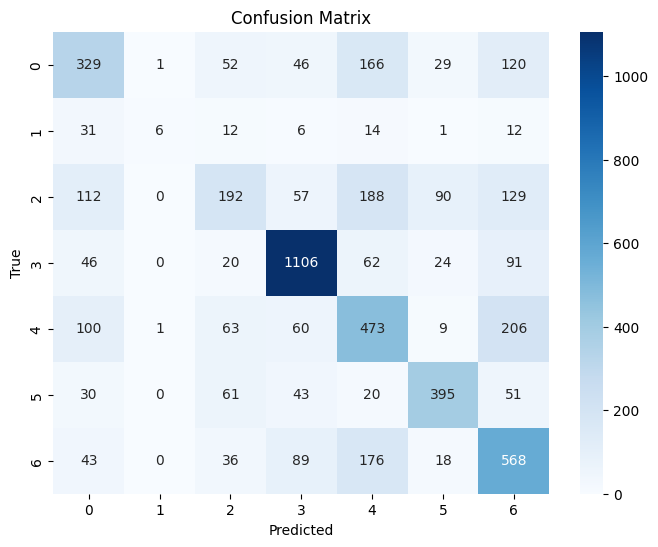

In [15]:
# Quick evaluation and confusion matrix
from sklearn.metrics import classification_report, confusion_matrix
val_steps = val_gen.samples // val_gen.batch_size
preds = model.predict(val_gen, verbose=1)
y_pred = np.argmax(preds, axis=1)
y_true = val_gen.classes
labels = list(val_gen.class_indices.keys())
print('\nClassification Report:')
print(classification_report(y_true, y_pred, target_names=labels))
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Notes
- If you have limited GPU, reduce `BATCH_SIZE` and `EPOCHS`.
- Use class weights for imbalanced classes (compute from `train_gen.class_indices`).
- Consider using `tf.data` pipelines for faster loading on large datasets.